In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time

import matplotlib.pyplot as plt

import scipy
from scipy import linalg

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from WrapScalableSVM import *
from Utils_SSVM import *
from utilsData import *
from modelEvaluation import *
from utilsPlot import *

import joblib

# Tests for the xAI-2024 conference paper
# Load datasets

In [2]:
datapath = "/Users/saranarteni/OneDrive - CNR/REXASI-PRO/T3.1/navground_code/simulation2/"
train = "train.csv"
test = "test.csv"
cal = "calib.csv"

In [3]:
dbtrain = pd.read_csv(datapath+train)
dbtest = pd.read_csv(datapath+test)
dbcal = pd.read_csv(datapath+cal)
dbtrain

,SafetyMargin,Eta,Tau,output
0,0.072754,0.696000,0.843175,0
1,0.070435,0.242085,0.406416,1
2,0.059769,0.205506,0.674503,1
3,0.085892,0.780026,0.053480,0
4,0.049805,0.959057,0.293833,0
...,...,...,...,...
3995,0.057952,0.187594,0.005126,0
3996,0.079647,0.857238,0.409003,0
3997,0.024324,0.841866,0.050738,0
3998,0.035507,0.377760,0.395691,1


Separate features and labels, and convert label 0 with 1 and 1 with -1

In [4]:
Xtr = dbtrain[['SafetyMargin', 'Eta', 'Tau']].values
Ytr = dbtrain[['output']].values
Ytr[Ytr==1] = -1
Ytr[Ytr==0] = 1

Xts = dbtest[['SafetyMargin', 'Eta', 'Tau']].values
Yts = dbtest[['output']].values
Yts[Yts==1] = -1
Yts[Yts==0] = 1

Xcal = dbcal[['SafetyMargin', 'Eta', 'Tau']].values
Ycal = dbcal[['output']].values
Ycal[Ycal==1] = -1
Ycal[Ycal==0] = 1

# SVM parameters setting

In [5]:
# Parameters settings
kernel = "polynomial"
param = 3
tau = np.array([[0.5]])
eta = 0.3

# Scaling setting

In [6]:
epsilon = 0.1

## 1) Classic SVM

In [7]:
start_time = time.time()

model = ScalableSVMClassifier(eta, kernel, param, tau)
model.get_params()

model = model.fit(Xtr,Ytr)
#joblib.dump(model, datapath+"classicSVM_safeEff.sav")
end_time = time.time()

elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 403.1515438556671 seconds


In [8]:
model = model.FPcontrol(Xcal, Ycal, epsilon,'classic')
model.b_eps

0

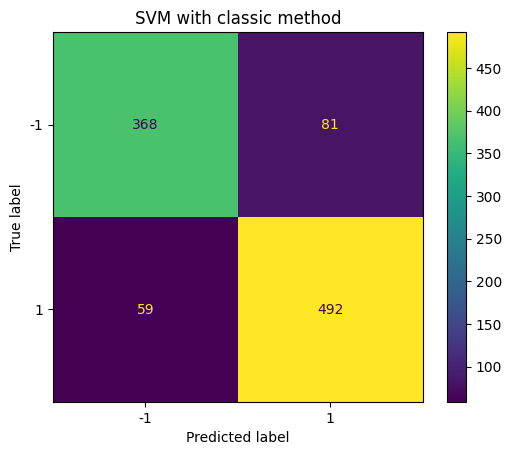

ACC = 0.86, F1 = 0.8754448398576512, PPV = 0.8586387434554974, NPV = 0.8618266978922716, TPR = 0.8929219600725953, TNR = 0.8195991091314031, FPR = 0.18040089086859687, FNR = 0.10707803992740472

TP = 492, FP = 81, TN = 368, FN = 59


In [9]:
metricsClassic = EvaluateModel(model, Xts, Yts, f"SVM with {model.method} method")


In [30]:
#joblib.dump(model,datapath+"Classic_SVM_safe.sav")

['/Users/saranarteni/OneDrive - CNR/REXASI-PRO/T3.1/navground_code/simulation2/Classic_SVM_safe.sav']

## 2) Probabilistic Safety Region

In [37]:
model = model.FPcontrol(Xcal, Ycal, epsilon,'ps')
model.b_eps

0.21856089114097121

In [38]:
model.get_params()

{'eta': 0.3,
 'kernel': 'polynomial',
 'param': 3,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

In [40]:
#joblib.dump(model,datapath+"PS_SVM_safe.sav")

['/Users/saranarteni/OneDrive - CNR/REXASI-PRO/T3.1/navground_code/simulation2/PS_SVM_safe.sav']

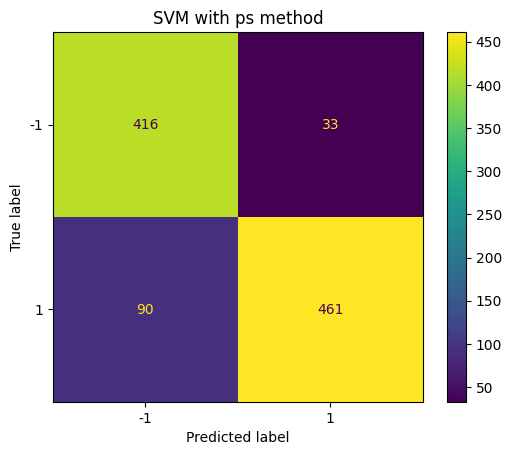

ACC = 0.877, F1 = 0.8822966507177034, PPV = 0.9331983805668016, NPV = 0.8221343873517787, TPR = 0.8366606170598911, TNR = 0.9265033407572383, FPR = 0.07349665924276169, FNR = 0.16333938294010888

TP = 461, FP = 33, TN = 416, FN = 90


In [39]:
metricsPSR = EvaluateModel(model, Xts, Yts, f"SVM with {model.method} method")

In [42]:
# save to file
y_ps_tr = model.predict(Xtr).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr,Ytr,y_ps_tr)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal,Ycal,y_ps_cal)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts,Yts,y_ps_ts)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
#train.to_csv(datapath+"train_ps.csv", index = False)
#calib.to_csv(datapath+"calib_ps.csv", index = False)
#test.to_csv(datapath+"test_ps.csv", index = False)

In [41]:
y_ps_tr.shape

(4000, 1)

In [46]:
len(model.alpha)

4000

In [45]:
from scipy.io import savemat
# save alpha for matlab plots
#savemat(datapath+"psr_alpha.mat", {"alpha": model.alpha})

# 3) Conformal Safety Regions


In [18]:
model = model.FPcontrol(Xcal, Ycal, 0.1,'cp')
model.b_eps

0.14489055974142745

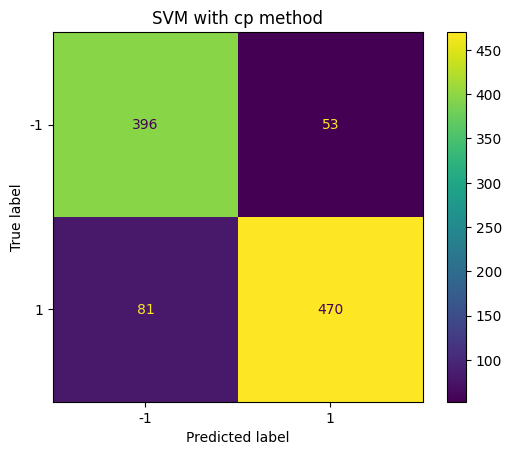

ACC = 0.866, F1 = 0.8752327746741154, PPV = 0.8986615678776291, NPV = 0.8301886792452831, TPR = 0.852994555353902, TNR = 0.8819599109131403, FPR = 0.11804008908685969, FNR = 0.147005444646098

TP = 470, FP = 53, TN = 396, FN = 81


In [19]:
metricsCSR = EvaluateModel(model, Xts, Yts, f"SVM with {model.method} method")

In [20]:
# save to file
y_ps_tr = model.predict(Xtr).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr,Ytr,y_ps_tr)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal,Ycal,y_ps_cal)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts,Yts,y_ps_ts)), columns = ["SafetyMargin","Eta","Tau","y_true","y_conformal"])
#train.to_csv(datapath+"train_cp.csv", index = False)
#calib.to_csv(datapath+"calib_cp.csv", index = False)
#test.to_csv(datapath+"test_cp.csv", index = False)

In [21]:
#joblib.dump(model,datapath+"CP_SVM_safe.sav")

['/Users/saranarteni/OneDrive - CNR/REXASI-PRO/T3.1/navground_code/simulation2/CP_SVM_safe.sav']